<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch
## Main_RandomTic_Continuous_AVDataset_Dow30_Daily
Network: 128x64x32x16

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Check Additional Packages](#1.1)
    * [2.2. Import Packages](#1.2)
    * [2.3. Create Folders & Relevant Configurations¶](#1.3)
* [3. Download Data](#2)
* [4. Preprocess fundamental data](#3)        
    * [4.1. Import the financial data](#3.1)
    * [4.2. Specify items needed to calculate financial ratios](#3.2)
    * [4.3. Turn the final_ratios to daily basis](#3.3)
    * [4.4. Merge stock price data and ratios into one dataframe](#3.4)
    * [4.5. Finish data preparation](#3.5)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. Set up the training environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Train DRL Agent](#5)  
* [7.Backtest Our Strategy](#6)  
    * [7.1. BackTest with DJIA](#6.1)
    * [7.2. BackTest with Buy&Hold Strategy](#6.2)
* [8.Save & load model](#7)
    * [8.1. Save model](#7.1)
    * [8.2. Load model](#7.2)

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−1, ... ,0, ..., 1}, to denote the magnitude of the transaction based on the proportion of a baseline asset.
For example, "Buy AAPL with 10% remain capital" or "Sell 10% shares of AAPL" are 0.1 or −0.1, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents from 1st January,2012 to 31st December 2021


The data of the single stock that we will be using for this case study is obtained from Alpha Vantage API. The data contains Open-High-Low-Close price and volume.


### If continuing the previous training, jump to [**this point**](#8.1)

<a id='1'></a>
# Part 2. Getting Started- Load Python Packages


<a id='1.1'></a>
## 2.1. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.2'></a>
## 2.2. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import math
from stable_baselines3.common.logger import configure

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.3'></a>
## 2.3. Create Folders & Relevant Configurations

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [4]:
from datetime import datetime
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

# Load price data from csv file
tic_dir = './' + DATA_SAVE_DIR + '/sp500_price_daily.csv'
df = pd.read_csv(tic_dir,index_col=0)

If the data is available locally, we can skip downloading steps and jump directly to part [**4.5.Finish data preparation**](#3.5)

<a id='2'></a>
# Part 3. Download Price Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# Download data from YFinance
# tic_dir = './' + DATA_SAVE_DIR + '/sp500_ticker.csv'
# tic_list = pd.read_csv(tic_dir,index_col=0)
# SP_500_TICKER = np.array(tic_list.tic).tolist()
# df = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = SP_500_TICKER).fetch_data()

In [6]:
# df.head()

In [7]:
# df.tail()

In [8]:
# df.shape

In [9]:
# df.sort_values(['date','tic']).head()

In [10]:
# len(df.tic.unique())

In [11]:
# df.tic.value_counts()

<a id='3'></a>
# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Alpha Vantage
- Preprocess the dataset and calculate financial ratios
- Turn yearly ratio into daily basis

<a id='3.1'></a>
## 4.1 Import the financial data

#### Define configurations of the collecting data & download data via Alpha Vantage API

In [12]:
# import requests

# api_key = 'GZWRUSYXT18ZTR6C'
# features_cols = ['fiscalDateEnding','totalRevenue','costOfRevenue','sellingGeneralAndAdministrative','researchAndDevelopment','depreciation','interestExpense','totalCurrentLiabilities','incomeTaxExpense','netIncome','commonStockSharesOutstanding','cashAndCashEquivalentsAtCarryingValue','cashAndShortTermInvestments','operatingCashflow','totalLiabilities','inventory','currentNetReceivables','propertyPlantEquipment','capitalExpenditures','longTermInvestments','totalShareholderEquity','longTermDebt','retainedEarnings','dividendPayoutCommonStock','paymentsForRepurchaseOfCommonStock','treasuryStock','currentLongTermDebt']
# price_cols = ['open','high','low','close','volume']

Function to download fundamental data from financial reports by ticket

In [13]:
# def collect_fundamental(ticket):
#     # Download income statement
#     url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_is = r.json()

#     # Download balance sheet
#     url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_bs = r.json()

#     # Download cash flow
#     url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_cf = r.json()

#     df_is = pd.json_normalize(data_is['annualReports'])
#     df_bs = pd.json_normalize(data_bs['annualReports'])
#     df_cf = pd.json_normalize(data_cf['annualReports'])

#     merged_df = df_is.merge(df_bs).merge(df_cf)
#     merged_df['tic'] = ticket
#     merged_df = merged_df[['tic']+features_cols]
#     merged_df['fiscalDateEnding'] = pd.to_datetime(merged_df.fiscalDateEnding,format='mixed')

#     return merged_df

Function to download stock price by ticket

In [14]:
# def collect_price(ticket):
#     url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_monthly_price = r.json()

#     price_monthly = pd.DataFrame.from_dict(data_monthly_price['Monthly Time Series'], orient='index')
#     price_monthly.columns = price_cols
#     price_monthly['fiscalDateEnding'] = pd.to_datetime(price_monthly.index,format='mixed')
#     price_monthly.reset_index(inplace=True,drop=True)
#     price_monthly = price_monthly[['fiscalDateEnding','open','high','low','close','volume']]
#     return price_monthly

Function to merge monthly stock price into yearly fundamental data

In [15]:
# def merge_price_to_df(merged_df,price_monthly):
#     merged_df['year'] = merged_df.fiscalDateEnding.dt.year
#     merged_df['month'] = merged_df.fiscalDateEnding.dt.month
#     price_monthly['year'] = price_monthly.fiscalDateEnding.dt.year
#     price_monthly['month'] = price_monthly.fiscalDateEnding.dt.month
#     merged_final = pd.merge(merged_df,price_monthly,how="left",on=['year','month'])
#     merged_final.drop(columns=['year','month','fiscalDateEnding_y'],inplace=True)
#     merged_final = df_final.rename(columns={'fiscalDateEnding_x': 'date'})
#     merged_final['tic'] = ticket

#     merged_columns = [merged_final.columns[-1]]
#     for i in range(0,len(merged_final.columns)-1):
#         merged_columns.append(merged_final.columns[i])
#     merged_final = merged_final[merged_columns]
    
#     return merged_final

In [16]:
# download_tics = SP_500_TICKER[453:]
# print(download_tics)

In [17]:
# fund_data = pd.DataFrame()

# for ticket in download_tics:
#     df_fund = collect_fundamental(ticket)
#     fund_data = pd.concat([fund_data, df_fund], ignore_index=True)

In [18]:
# fund_data.to_csv('sp500_6.csv')

In [19]:
# Check dropped tickers which are not available data to download from Alpha Vantage

# tics_1 = pd.DataFrame()
# tics_2 = pd.DataFrame()
# tics_1['tic'] = df.tic.unique()
# tics_2['tic'] = fund_data.tic.unique()

# merged_df = tics_1.merge(tics_2, how='outer', indicator=True)
# unique_in_df = merged_df[merged_df['_merge'] == 'left_only']
# unique_in_df

#### Check reach download limitation

In [20]:
# url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=IBM&apikey=GZWRUSYXT18ZTR6C'
# r = requests.get(url)
# data_is = r.json()
# data_is

#### Load data from csv file

In [21]:
# fund_data = pd.read_csv('./' + DATA_SAVE_DIR + '/dow30_fundamental.csv',index_col=0)
# # fund_data = fund_data.rename(columns={'fiscalDateEnding_x':'date'})
# fund_data['date'] = pd.to_datetime(fund_data.date,format='mixed')
# fund_data

Select tickers in DJ index only.

In [22]:
# fund_data = fund_data[fund_data.tic.isin(DOW_30_TICKER)].reset_index(drop=True)
# fund_data.tic.nunique()

In [23]:
# # UTIL TOOL: merge yearly fundamental data to daily stock price

# start_date = df.iloc[0].date
# end_date = df.iloc[-1].date
# date_range = pd.date_range(start=start_date, end=end_date, freq='D')
# date_range = pd.DataFrame(date_range)
# date_range.columns = ['date']

# fund_data = fund_data.rename(columns={'fiscalDateEnding':'date'})
# fund_data['date'] = pd.to_datetime(fund_data.date,format='mixed')

# fund_data_with_price = pd.DataFrame()
# for ticket in fund_data.tic.unique():
#     price_by_ticket = df[df.tic == ticket]
#     price_by_ticket['date'] = pd.to_datetime(price_by_ticket['date'],format='mixed')
#     price_by_ticket = pd.merge(date_range,price_by_ticket,how='left')
#     price_by_ticket.bfill(inplace=True)
#     price_by_ticket = pd.merge(fund_data.loc[fund_data.tic==ticket],price_by_ticket,how='left',on=['date'])
#     price_by_ticket.drop(columns=['tic_y','day'],inplace=True,axis=0)
#     price_by_ticket = price_by_ticket.rename(columns={'tic_x':'tic'})
#     fund_data_with_price = pd.concat([fund_data_with_price, price_by_ticket], ignore_index=True)

# fund_data = fund_data_with_price

#### Data cleaning ####
Refine the data before computing fundamental ratios

In [24]:
# print(fund_data.info(),'\n')
# print(fund_data.isna().sum())

The company with zero totalRevenue might cause problems for computing ratios while it is the denominator in some formulars.<br>
Deleting all tickers containing this issue is a good solution.

In [25]:
# zero_revenue_tics = fund_data[fund_data.totalRevenue == 0].tic.unique()
# fund_data = fund_data[~fund_data.tic.isin(zero_revenue_tics)]
# fund_data[fund_data.totalRevenue == 0]

While removing zero revenue data was neccessary, other columns with zero values might indicate some potential issues that require further investigations

In [26]:
# column_nan = fund_data.eq(0).any()
# column_nan

In [27]:
# fund_data = fund_data.fillna(0)
# # for i in fund_data.columns:
# #     print(i,'\n',fund_data[i].unique(),'\n')

<a id='3.2'></a>
## 4.2 Compute fundamental ratio

Define support functions before computing fundamental ratios

In [28]:
# # Define a function to count positive values within a window
# def count_positives(window):
#   return window[window > 0].count()

# def count_positives_window(data,k):
#     df = pd.DataFrame(data, columns=['values'])

#     # Create a new column with the adjusted positive count (using a shifted window)
#     df['positive_count'] = df['values'].rolling(window=k, min_periods=1).apply(count_positives)

#     # Set positive_count of the first k rows to positive_count of row k
#     df.loc[:k-1,'positive_count'] = df.loc[k-1].positive_count

#     return df

In [29]:
# # Define a function to get min items in a window
# def get_min(window):
#   return window.min()

# def min_in_window(data,k):
#     df = pd.DataFrame(data, columns=['values'])

#     # Create a new column with the min in the window (using a shifted window)
#     df['min'] = df['values'].rolling(window=k, min_periods=1).apply(get_min)

#     return df

At this point, data and supporting functions are ready for computing fundamental ratios required

In [30]:
# def compute_fund_ratios(df_final):
#     pos_count_window = 10  # number of years to look back for count_positive_profit
#     min_ebit_window = 4  # number of years to look back for min_ebit
    
#     gross_income = df_final.totalRevenue - df_final.costOfRevenue
#     ebit = gross_income - df_final.sellingGeneralAndAdministrative
#     profit = ebit - df_final.interestExpense - df_final.incomeTaxExpense
#     market_equity = df_final.commonStockSharesOutstanding * df_final.close
#     market_asset = df_final.totalLiabilities + market_equity
    
#     # Gross profit margin
#     gross_profit_margin = (gross_income/df_final.totalRevenue).to_frame('gross_profit_margin')
    
#     # SGA Expense / Gross Profit
#     sga_ratio = (df_final.sellingGeneralAndAdministrative/gross_income).to_frame('sga_ratio')
    
#     # Depreciation / Gross Profit
#     dep_ratio = (df_final.depreciation/gross_income).to_frame('dep_ratio')
    
#     # EBIT / Bond interest
#     ebit_on_int = (ebit/df_final.interestExpense).to_frame('ebit_on_int')
    
#     # Profit margin
#     profit_margin = (profit/df_final.totalRevenue).to_frame('profit_margin')
    
#     # Amount of positive profit within a window
#     count_positive_profit = count_positives_window(profit,pos_count_window)
#     count_positive_profit = count_positive_profit['positive_count'].to_frame('count_positive_profit')
#     count_positive_profit = count_positive_profit / pos_count_window # Standadize the positive profit
    
#     # Cash And Short Term Investments / Total Liabilities
#     csti_on_liabilities = (df_final.cashAndShortTermInvestments/df_final.totalLiabilities).to_frame('csti_on_liabilities')
    
#     # Inventory / EBIT
#     inventory_on_ebit = (df_final.inventory / ebit).to_frame('inventory_on_ebit')
    
#     # Receivable / Revenue
#     receivable_on_rev = (df_final.currentNetReceivables / df_final.totalRevenue).to_frame('receivable_on_rev')
    
#     # ROA
#     roa = (profit / market_asset).to_frame('roa')
    
#     # ROE
#     roe = (profit / market_equity).to_frame('roe')
    
#     # Long-term debt / minEBIT
#     min_ebit = min_in_window(ebit,min_ebit_window)['min']
#     debt_on_min_ebit = (df_final.longTermDebt / min_ebit).to_frame('debt_on_min_ebit')
    
#     # Total Liabilities / Total Equity
#     liabilities_on_equity = (df_final.totalLiabilities / market_equity).to_frame('liabilities_on_equity')
    
#     # Capital Expenditures / EBIT
#     capital_cost_on_ebit = (df_final.capitalExpenditures / ebit).to_frame('capital_cost_on_ebit')
    
#     # EPS / MP
#     eps = profit / df_final.commonStockSharesOutstanding
#     eps_on_mp = (eps / df_final.close).to_frame('eps_on_mp')
    
#     # Cash and Stock Dividend & Repurchase Common / MP
#     dividend_on_mp = ((df_final.dividendPayoutCommonStock + df_final.paymentsForRepurchaseOfCommonStock) / df_final.close).to_frame('dividend_on_mp')
    
#     # MP / BV
#     mp_on_bv = (df_final.close / (df_final.cashAndShortTermInvestments + df_final.currentNetReceivables*0.8 +df_final.inventory*0.5 + df_final.propertyPlantEquipment*0.2 + df_final.longTermInvestments - df_final.totalLiabilities)).to_frame('mp_on_bv')

#     # Turn market-relevance metrics to dataframe
#     profit = profit.to_frame('profit')
#     common_stock = df_final.commonStockSharesOutstanding.to_frame('common_stock')
#     total_liabilities = df_final.totalLiabilities.to_frame('total_liabilities')   
#     eps = eps.to_frame('eps')
#     dividend = (df_final.dividendPayoutCommonStock + df_final.paymentsForRepurchaseOfCommonStock).to_frame('dividend')
#     bv = (df_final.cashAndShortTermInvestments + df_final.currentNetReceivables*0.8 +df_final.inventory*0.5 + df_final.propertyPlantEquipment*0.2 + df_final.longTermInvestments - df_final.totalLiabilities).to_frame('bv')
    
#     # Create a dataframe that merges all the ratios
#     ratios = pd.concat([df_final.date,df_final.tic,df_final.close,profit,common_stock,total_liabilities,eps, dividend, bv,
#                         gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,
#                         csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,
#                         liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv,], axis=1)
    
#     return ratios

In [31]:
# ratios = compute_fund_ratios(fund_data)
# ratios

#### At this point, we must do some feature engineering on ratios to ensure the trends and fluctuations are able to be computed

Check columns with inf values

In [32]:
# ratio_list = ratios.columns.drop(['date','tic'])
# check_ratios = ratios[ratio_list]
# inf_cols = check_ratios.columns[~np.isfinite(check_ratios).all()]
# inf_cols

Check rows with inf values

In [33]:
# ratio_inf = ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]
# print(len(ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]))
# ratio_inf.head()

The **ebit_on_int** has infinity values for companies without banking support. We need to address these cases separately: <br>
 * Replace positive inf with maximum value in ebit_on_int
 * Replace negative inf with minimum value in ebit_on_int

In [34]:
# ratio_finite = ratios[~((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]
# ratios['ebit_on_int'] = ratios.ebit_on_int.replace(np.inf,ratio_finite.ebit_on_int.max())
# ratios['ebit_on_int'] = ratios.ebit_on_int.replace(-np.inf,ratio_finite.ebit_on_int.min())
# print(len(ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]))

#### Define support functions using for computing trends and fluctuations of certain ratios

In [35]:
# # Define a function to get different of values in a window
# def trend_in_window(data,window_size):
#     df = data.to_frame('values')
#     if window_size <= 0:
#         raise ValueError("Window size must be a positive integer.")
    
#     # Handle cases where the DataFrame has fewer elements than the window size
#     if len(df) < window_size:
#         return pd.Series(np.nan, index=df.index)
    
#     # Use rolling window with offset to get the difference
#     differences = df.iloc[:, 0].rolling(window=window_size, min_periods = 1).apply(lambda x: (x[-1] - x[0])/window_size, raw=True)
    
#     return differences

In [36]:
# # Define a function to get fluctuations of items in a window

# def fluctuation_in_window(data, window_size):

#     df = data.to_frame('values')
#     if window_size <= 0:
#         raise ValueError("Window size must be a positive integer.")
    
#     def calculate_fluctuation(x):
#         # Handle cases where the window size is larger than the available data
#         if (len(x) == 1):
#             return 0
#         else:
#             return np.std(x)
    
#     # Apply rolling window with custom function for fluctuation calculation
#     fluctuations = df.iloc[:, 0].rolling(window=window_size, min_periods=1).apply(calculate_fluctuation, raw=True)
    
#     return fluctuations

In [37]:
# def compute_stats(ratios):
    
#     trend_window = 3 # interval of computing gross_margin and profit_margin trends
#     fluc_window = 5 # interval of computing fluctuations of ratios
    
#     # Gross Profit Margin 3 years trending
#     trend_gross_margin = trend_in_window(ratios.gross_profit_margin,trend_window).to_frame('trend_gross_margin')
    
#     # Profit Margin 3 years trending
#     trend_profit_margin = trend_in_window(ratios.profit_margin,trend_window).to_frame('trend_profit_margin')

#     # Stde of SGA
#     fluc_sga = fluctuation_in_window(ratios.sga_ratio, fluc_window).to_frame('fluc_sga')

#     # Stde of dep_ratio
#     fluc_dep_ratio = fluctuation_in_window(ratios.dep_ratio, fluc_window).to_frame('fluc_dep_ratio')

#     # Stde of inventory_on_ebit
#     fluc_inv_on_ebit = fluctuation_in_window(ratios.inventory_on_ebit, fluc_window).to_frame('fluc_inv_on_ebit')

#     # Stde of receivable_on_revenue
#     fluc_rec_on_rev = fluctuation_in_window(ratios.receivable_on_rev, fluc_window).to_frame('fluc_rec_on_rev')

#     stats = pd.concat([trend_gross_margin,trend_profit_margin,fluc_sga,fluc_dep_ratio,fluc_inv_on_ebit,fluc_rec_on_rev], axis=1)
    
#     return stats

In [38]:
# add_stats = pd.DataFrame()
# for tic in ratios.tic.unique():
#     tic_ratios = ratios[ratios.tic == tic].reset_index(drop=True)
#     tic_ratios.sort_values(['date'],ascending=True,inplace=True)
#     tic_ratios = pd.concat([tic_ratios,compute_stats(tic_ratios)],axis=1)
#     add_stats = pd.concat([add_stats,tic_ratios],ignore_index=True)
# add_stats

In [39]:
# add_stats.to_csv('./' + DATA_SAVE_DIR + '/dow30_fund_with_filter_yearly.csv')

<a id='3.3'></a>
## 4.3 Turn the final_ratios to daily basis¶
After our initial inspection, we’ll want to dig deeper to investigate the following:
- The data type of each variable.
- How discrete/categorical data is coded (and whether we need to make any changes).
- How the data are scaled.
- Whether there is missing data and how it is coded.
- Whether there are outliers.
- The distributions of continuous features.
- The relationships between pairs of features.

### Data types
It is important to check the data type for each feature. <br>
The **date** should be in datetime type <br>
The **ratios** should be read in as float64 — and categorical variables should be stored as object 

In [40]:
# ratios = pd.read_csv('./' + DATA_SAVE_DIR + '/dow30_fund_with_filter_yearly.csv',index_col=0)
# ratios['date'] = pd.to_datetime(ratios['date'],format='mixed')
# ratios

Remove the first year of each ticker to remove zero trends and fluctuations

In [41]:
# ratios = ratios[ratios.date.dt.year != 2015]

We see that there is no missing values from all ratios

### Turn the final_ratios to daily basis

In [42]:
# start_date = df.iloc[0].date
# end_date = df.iloc[-1].date
# date_range = pd.date_range(start=start_date, end=end_date, freq='D')
# date_range = pd.DataFrame(date_range)
# date_range.columns = ['date']
# date_range.head()

Interpolate missing data in the middle of years for each ticket

In [43]:
# daily_ratios = pd.DataFrame()
# for ticket in ratios.tic.unique():
#     # Interpolate data for each ticket
#     one_tic_ratios = pd.merge(date_range,ratios[ratios.tic == ticket],how="left",on=['date'])
#     one_tic_ratios['tic'] = ticket
#     one_tic_ratios.ffill(axis=0, inplace=True)
#     daily_ratios = pd.concat([daily_ratios, one_tic_ratios], ignore_index=True)

#     # Check data by drawing it out
#     %matplotlib inline
#     plt.figure(figsize=(16, 4)) 
#     plt.plot(one_tic_ratios.date, one_tic_ratios.gross_profit_margin, color = 'red')
#     plt.title(f'Gross profit margin of {ticket}')
#     plt.show()

In [44]:
# daily_ratios.dropna(subset='gross_profit_margin',inplace=True)
# daily_ratios.reset_index(inplace=True,drop=True)
# daily_ratios

<a id='3.4'></a>
## 4.4 Merge stock price data and ratios into one dataframe
- Merge the price dataframe preprocessed in Part 3 and the ratio dataframe created in this part
- Since the prices are daily and ratios are quartely, we have NAs in the ratio columns after merging the two dataframes. We deal with this by backfilling the ratios.

In [45]:
# daily_ratios.drop(columns=['close'],inplace=True)
# df_date = pd.DataFrame(df)[['date','tic','close']]
# df_date.columns = ['date','tic','close']
# df_date['date'] = pd.to_datetime(df_date.date)
# final_ratios = pd.merge(daily_ratios,df_date,how="left",on=['date','tic'])
# final_ratios

In [46]:
# final_ratios.dropna(subset=['close'],inplace=True,how='any')
# final_ratios.reset_index(drop=True,inplace=True)
# final_ratios.isna().sum()

In [47]:
# def compute_market_ratios(df_final):
    
#     market_equity = df_final.common_stock * df_final.close
#     market_asset = df_final.total_liabilities + market_equity

#     # ROA
#     roa = (df_final.profit / market_asset).to_frame('roa')
    
#     # ROE
#     roe = (df_final.profit / market_equity).to_frame('roe')
    
#     # Total Liabilities / Total Equity
#     liabilities_on_equity = (df_final.total_liabilities / market_equity).to_frame('liabilities_on_equity')
    
#     # EPS / MP
#     eps_on_mp = (df_final.eps / df_final.close).to_frame('eps_on_mp')
    
#     # Cash and Stock Dividend & Repurchase Common / MP
#     dividend_on_mp = (df_final.dividend / market_equity).to_frame('dividend_on_mp')
    
#     # MP / BV
#     mp_on_bv = (market_equity / df_final.bv).to_frame('mp_on_bv')
    
#     # Create a dataframe that merges all the ratios
#     ratios = pd.concat([roa,roe,liabilities_on_equity,eps_on_mp,dividend_on_mp,mp_on_bv], axis=1)
    
#     return ratios

In [48]:
# market_ratios = compute_market_ratios(final_ratios)

In [49]:
# ratios = final_ratios.drop(columns=['roa','roe','liabilities_on_equity','eps_on_mp','dividend_on_mp','mp_on_bv'])
# ratios = pd.concat([ratios,market_ratios],axis=1)

In [50]:
# columns = ['date', 'tic', 'close', 'profit', 'common_stock', 'total_liabilities', 'eps',
#         'dividend', 'bv', 'gross_profit_margin', 'sga_ratio', 'dep_ratio','ebit_on_int', 'profit_margin', 
#         'count_positive_profit','csti_on_liabilities', 'inventory_on_ebit', 'receivable_on_rev','roa', 'roe', 'liabilities_on_equity',
#         'debt_on_min_ebit', 'capital_cost_on_ebit','eps_on_mp', 'dividend_on_mp', 'mp_on_bv', 'trend_gross_margin',
#         'trend_profit_margin', 'fluc_sga', 'fluc_dep_ratio', 'fluc_inv_on_ebit','fluc_rec_on_rev']
# ratios = ratios[columns]
# ratios.columns

In [51]:
# ratios.drop(columns=['profit', 'common_stock', 'total_liabilities','eps', 'dividend', 'bv'],inplace=True)

In [52]:
# ratios.to_csv('./' + DATA_SAVE_DIR + '/dow30_ready_with_filter_data_daily.csv')

<a id='3.5'></a>
## 4.5 Finish data preparation

<a id='3.5.1'></a>
### 4.5.1 Load available data

In [53]:
# If the data is available in the data storage, load processed_full from readied data
processed_full = pd.read_csv('./' + DATA_SAVE_DIR + '/dow30_ready_daily_forGame.csv',index_col=0)
processed_full['date'] = pd.to_datetime(processed_full.date,format='mixed')
processed_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100976 entries, 0 to 100975
Data columns (total 61 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   date                                   100976 non-null  datetime64[ns]
 1   tic                                    100976 non-null  object        
 2   totalRevenue                           100976 non-null  float64       
 3   costOfRevenue                          100976 non-null  float64       
 4   sellingGeneralAndAdministrative        100976 non-null  float64       
 5   researchAndDevelopment                 100976 non-null  float64       
 6   depreciation                           100976 non-null  float64       
 7   interestExpense                        100976 non-null  float64       
 8   totalCurrentLiabilities                100976 non-null  float64       
 9   incomeTaxExpense                       100976 non-nul

In [54]:
processed_full = processed_full[processed_full.tic.isin(DOW_30_TICKER)]
processed_full.tic.unique()

array(['WBA', 'AAPL', 'MSFT', 'V', 'UNH', 'JNJ', 'JPM', 'WMT', 'PG', 'HD',
       'CVX', 'MRK', 'KO', 'CSCO', 'MCD', 'CRM', 'NKE', 'DIS', 'AMGN',
       'CAT', 'VZ', 'INTC', 'BA', 'IBM', 'HON', 'AXP', 'GS', 'MMM', 'DOW',
       'TRV'], dtype=object)

In [55]:
processed_full

,date,tic,totalRevenue,costOfRevenue,sellingGeneralAndAdministrative,researchAndDevelopment,depreciation,interestExpense,totalCurrentLiabilities,incomeTaxExpense,...,open,high,low,close,volume,close_5_sma,close_20_sma,close_60_sma,close_120_sma,close_240_sma
0,2016-08-31,WBA,1.173510e+11,8.747700e+10,2.391000e+10,0.0,1.300000e+09,5.960000e+08,1.701300e+10,9.970000e+08,...,80.540001,80.830002,80.250000,60.654713,3282700.0,60.293992,61.218433,61.211967,60.677354,60.927799
1,2016-09-01,WBA,1.173534e+11,8.748132e+10,2.390973e+10,0.0,1.300000e+09,5.962658e+08,1.701720e+10,9.963507e+08,...,81.040001,81.709999,80.589996,61.278488,3296100.0,60.498407,61.295525,61.242776,60.682119,60.911777
2,2016-09-02,WBA,1.173557e+11,8.748563e+10,2.390947e+10,0.0,1.300000e+09,5.965315e+08,1.702141e+10,9.957014e+08,...,81.870003,82.250000,81.720001,61.789516,3029600.0,60.923769,61.372733,61.287464,60.692383,60.902620
3,2016-09-06,WBA,1.173652e+11,8.750289e+10,2.390841e+10,0.0,1.300000e+09,5.975945e+08,1.703822e+10,9.931041e+08,...,82.050003,82.139999,81.199997,61.353642,3726000.0,61.117657,61.424407,61.281746,60.694175,60.889402
4,2016-09-07,WBA,1.173676e+11,8.750721e+10,2.390814e+10,0.0,1.300000e+09,5.978603e+08,1.704242e+10,9.924548e+08,...,81.820000,83.059998,81.410004,62.285511,3315900.0,61.472374,61.512948,61.267995,60.696286,60.885263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100971,2024-04-30,TRV,4.136400e+10,6.385300e+10,5.176000e+09,0.0,0.000000e+00,3.760000e+08,8.060000e+08,3.800000e+08,...,212.750000,213.820007,211.740005,212.160004,1385700.0,213.185999,218.926500,219.719502,203.421700,184.737804
100972,2024-05-01,TRV,4.136400e+10,6.385300e+10,5.176000e+09,0.0,0.000000e+00,3.760000e+08,8.060000e+08,3.800000e+08,...,212.160004,215.240005,212.160004,213.149994,1143900.0,213.129999,218.131000,219.736765,203.795488,184.885378
100973,2024-05-02,TRV,4.136400e+10,6.385300e+10,5.176000e+09,0.0,0.000000e+00,3.760000e+08,8.060000e+08,3.800000e+08,...,213.869995,215.070007,212.419998,214.369995,1001400.0,213.205997,217.424500,219.775524,204.191241,185.031270
100974,2024-05-03,TRV,4.136400e+10,6.385300e+10,5.176000e+09,0.0,0.000000e+00,3.760000e+08,8.060000e+08,3.800000e+08,...,213.080002,214.360001,211.190002,213.850006,1298400.0,213.285999,216.572500,219.785541,204.582413,185.173446


In [56]:
# print(processed_full.describe())

In [57]:
# columns = ['date', 'tic', 'close', 'gross_profit_margin', 'sga_ratio', 'ebit_on_int', 'profit_margin', 'count_positive_profit',
#        'csti_on_liabilities', 'roa', 'roe', 'liabilities_on_equity', 'debt_on_min_ebit',
#        'capital_cost_on_ebit', 'eps_on_mp', 'dividend_on_mp', 'mp_on_bv',
#        'trend_gross_margin', 'trend_profit_margin', 'fluc_sga', 'fluc_dep_ratio', 'fluc_inv_on_ebit', 'fluc_rec_on_rev']
# processed_full = processed_full[columns]

Calculate price-relevant features

In [58]:
# processed_full.columns

In [59]:
processed_full['weekly_advance'] = processed_full.close - processed_full.close_5_sma
processed_full['monthly_advance'] = processed_full.close - processed_full.close_20_sma
processed_full['quaterly_advance'] = processed_full.close - processed_full.close_60_sma
processed_full['semiyearly_advance'] = processed_full.close - processed_full.close_120_sma
processed_full['yearly_advance'] = processed_full.close - processed_full.close_240_sma

<a id='3.5.2'></a>
### 4.5.2 Finished data

Reset **TRAIN_START_DATE** and **TEST_END_DATE**

In [60]:
TRAIN_START_DATE = processed_full.date.min().strftime("%Y-%m-%d")
TEST_END_DATE = processed_full.date.max().strftime("%Y-%m-%d")
print('TRAIN_START_DATE: ',TRAIN_START_DATE,'\n')
print('TRAIN_END_DATE: ',TRAIN_END_DATE,'\n')
print('TEST_START_DATE: ',TEST_START_DATE,'\n')
print('TEST_END_DATE: ',TEST_END_DATE,'\n')

TRAIN_START_DATE:  2009-09-30 

TRAIN_END_DATE:  2021-01-01 

TEST_START_DATE:  2021-01-01 

TEST_END_DATE:  2024-05-06 



### 4.5.3 Select only on ticker

In [61]:
selected_tic = 'AAPL'
selected_df = processed_full[processed_full.tic == selected_tic].reset_index(drop=True)
selected_df

,date,tic,totalRevenue,costOfRevenue,sellingGeneralAndAdministrative,researchAndDevelopment,depreciation,interestExpense,totalCurrentLiabilities,incomeTaxExpense,...,close_5_sma,close_20_sma,close_60_sma,close_120_sma,close_240_sma,weekly_advance,monthly_advance,quaterly_advance,semiyearly_advance,yearly_advance
0,2009-09-30,AAPL,4.290500e+10,2.983200e+10,4.149000e+09,1.333000e+09,0.000000e+00,3.260000e+08,1.150600e+10,3.831000e+09,...,5.581933,5.394381,5.015875,4.499253,3.686776,0.022254,0.209806,0.588312,1.104934,1.917411
1,2009-10-01,AAPL,4.296615e+10,2.987595e+10,4.152748e+09,1.334230e+09,0.000000e+00,3.255315e+08,1.153125e+10,3.832907e+09,...,5.564033,5.418085,5.037866,4.514532,3.697290,-0.095604,0.050344,0.430563,0.953897,1.771139
2,2009-10-02,AAPL,4.302730e+10,2.991990e+10,4.156496e+09,1.335460e+09,0.000000e+00,3.250630e+08,1.155650e+10,3.834814e+09,...,5.579332,5.445827,5.062327,4.531310,3.708182,0.011247,0.144752,0.528252,1.059269,1.882397
3,2009-10-05,AAPL,4.321075e+10,3.005174e+10,4.167740e+09,1.339151e+09,0.000000e+00,3.236575e+08,1.163225e+10,3.840534e+09,...,5.578547,5.469577,5.086264,4.548540,3.720092,0.045897,0.154867,0.538180,1.075905,1.904352
4,2009-10-06,AAPL,4.327190e+10,3.009569e+10,4.171488e+09,1.340381e+09,0.000000e+00,3.231890e+08,1.165750e+10,3.842441e+09,...,5.606545,5.495398,5.110286,4.565814,3.731825,0.138540,0.249687,0.634799,1.179271,2.013259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3669,2024-04-30,AAPL,3.793520e+11,2.390690e+11,2.493200e+10,2.991500e+10,8.500000e+09,3.933000e+09,1.453080e+11,1.674100e+10,...,170.408002,169.621500,175.117803,182.408039,181.395000,-0.078000,0.708502,-4.787801,-12.078037,-11.064998
3670,2024-05-01,AAPL,3.793520e+11,2.390690e+11,2.493200e+10,2.991500e+10,8.500000e+09,3.933000e+09,1.453080e+11,1.674100e+10,...,170.464001,169.604000,174.815456,182.307627,181.383705,-1.163998,-0.303997,-5.515453,-13.007624,-12.083702
3671,2024-05-02,AAPL,3.793520e+11,2.390690e+11,2.493200e+10,2.991500e+10,8.500000e+09,3.933000e+09,1.453080e+11,1.674100e+10,...,171.092001,169.814500,174.548310,182.229406,181.378158,1.937997,3.215499,-1.518312,-9.199407,-8.348159
3672,2024-05-03,AAPL,3.793520e+11,2.390690e+11,2.493200e+10,2.991500e+10,8.500000e+09,3.933000e+09,1.453080e+11,1.674100e+10,...,173.908002,170.504500,174.451833,182.241424,181.415278,9.472003,12.875505,8.928172,1.138581,1.964726


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

<a id='4.1'></a>
## 5.1 Training & Trade Data Split
- Training data period: 2009-01-01 to 2020-01-01
- Trade data period: 2020-01-01 to 2023-12-29

In [62]:
train_data = data_split(selected_df, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(selected_df, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(test_data))

2834
839


In [63]:
train_data = train_data.reset_index(drop=True)
train_data

,date,tic,totalRevenue,costOfRevenue,sellingGeneralAndAdministrative,researchAndDevelopment,depreciation,interestExpense,totalCurrentLiabilities,incomeTaxExpense,...,close_5_sma,close_20_sma,close_60_sma,close_120_sma,close_240_sma,weekly_advance,monthly_advance,quaterly_advance,semiyearly_advance,yearly_advance
0,2009-09-30,AAPL,4.290500e+10,2.983200e+10,4.149000e+09,1.333000e+09,0.000000e+00,3.260000e+08,1.150600e+10,3.831000e+09,...,5.581933,5.394381,5.015875,4.499253,3.686776,0.022254,0.209806,0.588312,1.104934,1.917411
1,2009-10-01,AAPL,4.296615e+10,2.987595e+10,4.152748e+09,1.334230e+09,0.000000e+00,3.255315e+08,1.153125e+10,3.832907e+09,...,5.564033,5.418085,5.037866,4.514532,3.697290,-0.095604,0.050344,0.430563,0.953897,1.771139
2,2009-10-02,AAPL,4.302730e+10,2.991990e+10,4.156496e+09,1.335460e+09,0.000000e+00,3.250630e+08,1.155650e+10,3.834814e+09,...,5.579332,5.445827,5.062327,4.531310,3.708182,0.011247,0.144752,0.528252,1.059269,1.882397
3,2009-10-05,AAPL,4.321075e+10,3.005174e+10,4.167740e+09,1.339151e+09,0.000000e+00,3.236575e+08,1.163225e+10,3.840534e+09,...,5.578547,5.469577,5.086264,4.548540,3.720092,0.045897,0.154867,0.538180,1.075905,1.904352
4,2009-10-06,AAPL,4.327190e+10,3.009569e+10,4.171488e+09,1.340381e+09,0.000000e+00,3.231890e+08,1.165750e+10,3.842441e+09,...,5.606545,5.495398,5.110286,4.565814,3.731825,0.138540,0.249687,0.634799,1.179271,2.013259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,2020-12-24,AAPL,2.929572e+11,2.000660e+11,2.039503e+10,1.948836e+10,9.653425e+09,2.819904e+09,1.100703e+11,1.080875e+10,...,127.522240,122.578958,117.028503,112.485891,93.341967,1.992241,6.935522,12.485978,17.028590,36.172514
2830,2020-12-28,AAPL,2.939603e+11,2.005644e+11,2.041757e+10,1.952301e+10,9.651233e+09,2.817405e+09,1.102904e+11,1.086187e+10,...,129.490912,123.565258,117.357288,112.826786,93.585358,4.655725,10.581379,16.789349,21.319851,40.561279
2831,2020-12-29,AAPL,2.942110e+11,2.006890e+11,2.042321e+10,1.953167e+10,9.650685e+09,2.816781e+09,1.103455e+11,1.087515e+10,...,130.794205,124.341540,117.717862,113.149456,93.817355,1.566299,8.018964,14.642642,19.211049,38.543150
2832,2020-12-30,AAPL,2.944618e+11,2.008136e+11,2.042884e+10,1.954033e+10,9.650137e+09,2.816156e+09,1.104005e+11,1.088843e+10,...,131.155356,124.881305,118.002804,113.461355,94.041111,0.076547,6.350598,13.229099,17.770548,37.190792


Adjust train_data to ensure the trajectory's length equals n_steps

In [64]:
for tic in train_data.tic.unique():
    print(f'{tic}:{len(train_data[train_data.tic == tic])}')

AAPL:2834


In [65]:
qualified_tics = ['AAPL', 'V', 'AMGN', 'AXP', 'BA', 'CAT', 'CVX', 'GS', 'HON', 'IBM',
       'INTC', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'TRV', 'UNH', 'VZ',
       'CRM', 'HD', 'WMT', 'NKE', 'MSFT', 'PG', 'CSCO', 'JNJ']
train_data = train_data[train_data.tic.isin(qualified_tics)]

In [66]:
n_steps = 2048
train_data_by_length = train_data.groupby('tic').tail(n_steps)
train_data_by_length.reset_index(inplace=True,drop=True)

In [67]:
for tic in train_data_by_length.tic.unique():
    print(f'{tic}:{len(train_data_by_length[train_data_by_length.tic == tic])}')

AAPL:2048


In [68]:
train_data = train_data_by_length

Because the predictions employ only the state, the model accepts any dataset as long as it provide appropriate input format

In [69]:
test_data = test_data.reset_index(drop=True)
test_data

,date,tic,totalRevenue,costOfRevenue,sellingGeneralAndAdministrative,researchAndDevelopment,depreciation,interestExpense,totalCurrentLiabilities,incomeTaxExpense,...,close_5_sma,close_20_sma,close_60_sma,close_120_sma,close_240_sma,weekly_advance,monthly_advance,quaterly_advance,semiyearly_advance,yearly_advance
0,2021-01-04,AAPL,2.957156e+11,2.014366e+11,2.045702e+10,1.958365e+10,9.647397e+09,2.813033e+09,1.106757e+11,1.095483e+10,...,130.992439,125.670345,118.563066,114.035818,94.470021,-3.990326,1.331769,8.439047,12.966296,32.532092
1,2021-01-05,AAPL,2.959664e+11,2.015612e+11,2.046265e+10,1.959231e+10,9.646849e+09,2.812408e+09,1.107307e+11,1.096811e+10,...,129.877577,126.100195,118.828664,114.310844,94.682190,-1.305251,2.472131,9.743663,14.261483,33.890137
2,2021-01-06,AAPL,2.962172e+11,2.016858e+11,2.046829e+10,1.960098e+10,9.646301e+09,2.811784e+09,1.107858e+11,1.098139e+10,...,128.254355,126.240044,118.989473,114.559604,94.877257,-4.009962,-1.995652,5.254919,9.684789,29.367135
3,2021-01-07,AAPL,2.964679e+11,2.018104e+11,2.047393e+10,1.960964e+10,9.645753e+09,2.811159e+09,1.108408e+11,1.099467e+10,...,127.704776,126.560960,119.099622,114.845283,95.099477,0.779233,1.923048,9.384386,13.638726,33.384532
4,2021-01-08,AAPL,2.967187e+11,2.019350e+11,2.047956e+10,1.961830e+10,9.645205e+09,2.810534e+09,1.108958e+11,1.100795e+10,...,127.579163,127.064906,119.282138,115.123660,95.317459,2.013809,2.528066,10.310834,14.469311,34.275513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,2024-04-29,AAPL,3.793520e+11,2.390690e+11,2.493200e+10,2.991500e+10,8.500000e+09,3.933000e+09,1.453080e+11,1.674100e+10,...,169.722000,169.546999,175.372522,182.478339,181.399430,3.778000,3.953001,-1.872522,-8.978339,-7.899430
835,2024-04-30,AAPL,3.793520e+11,2.390690e+11,2.493200e+10,2.991500e+10,8.500000e+09,3.933000e+09,1.453080e+11,1.674100e+10,...,170.408002,169.621500,175.117803,182.408039,181.395000,-0.078000,0.708502,-4.787801,-12.078037,-11.064998
836,2024-05-01,AAPL,3.793520e+11,2.390690e+11,2.493200e+10,2.991500e+10,8.500000e+09,3.933000e+09,1.453080e+11,1.674100e+10,...,170.464001,169.604000,174.815456,182.307627,181.383705,-1.163998,-0.303997,-5.515453,-13.007624,-12.083702
837,2024-05-02,AAPL,3.793520e+11,2.390690e+11,2.493200e+10,2.991500e+10,8.500000e+09,3.933000e+09,1.453080e+11,1.674100e+10,...,171.092001,169.814500,174.548310,182.229406,181.378158,1.937997,3.215499,-1.518312,-9.199407,-8.348159


<a id='4.2'></a>
## 5.2 Initialize Environment


State's space include remain_capital, price, stock_amount, current_return, and the indicators decided in ratio_list

In [70]:
features = ['close','close_5_sma','close_20_sma','close_60_sma','close_120_sma','close_240_sma',
            'gross_profit_margin', 'sga_ratio', 'ebit_on_int', 'profit_margin', 'count_positive_profit',
       'csti_on_liabilities', 'roa', 'roe', 'liabilities_on_equity', 'debt_on_min_ebit',
       'capital_cost_on_ebit', 'eps_on_mp', 'dividend_on_mp', 'mp_on_bv',
       'trend_gross_margin', 'trend_profit_margin', 'fluc_sga', 'fluc_dep_ratio', 'fluc_inv_on_ebit', 'fluc_rec_on_rev']
# ratio_list = train_data.columns.drop(['date','tic','close'])

action_dimension = 1 # k float in range (-1,1) to decide sell (k<0) or buy (k>0) decisions
state_space = 4 + len(features)
print(f"Action Dimension: {action_dimension}, State Space: {state_space}")

Action Dimension: 1, State Space: 30


#### Initiate environment

In [71]:
from trading_environment_end_reward import StockTradingEnv

# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "tech_indicator_list": features, 
    "state_space": state_space, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4,
    "stop_loss": 0.8,
    "print_verbosity":4,
    "hold_period": 5
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

In [72]:
from stable_baselines3.common.env_checker import check_env

# If the environment don't follow the interface, an error will be thrown
check_env(e_train_gym, warn=True)

In [73]:
from stable_baselines3 import PPO, A2C, DQN, DDPG

# Instantiate the env
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='8.1'></a>
#### If the training starts from the previous model, the section should **run all cells above** this line and then jump to [**Load trained model**](#7.2.1) to keep the traning going on.

#### Test Environment

In [82]:
# Get samples from train_data
test_env_data = train_data

#Establish the training environment using StockTradingEnv() class
test_train_gym = StockTradingEnv(df = test_env_data, **env_kwargs)

# test reset state
print(test_train_gym.reset())

(array([1.0000000e+06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.6560732e+01, 1.6646387e+01, 1.8107763e+01, 1.9574476e+01,
       1.8756325e+01, 1.7060223e+01, 3.4835634e-01, 1.8507423e-01,
       3.0824771e+03, 1.9610113e-01, 1.0000000e+00, 5.0136679e-01,
       4.0473822e-01, 1.9986641e+00, 3.9381649e+00, 5.5696119e-02,
       1.8546383e-01, 1.9964892e+00, 4.0178493e-01, 2.0384263e-01,
       1.6291354e-02, 1.7274035e-02, 5.3518008e-02, 0.0000000e+00,
       2.2196550e-02, 1.3035445e-02], dtype=float32), {})


In [83]:
for i in range(0,100):
    action = test_train_gym.action_space.sample()
    # print(test_train_gym.data)
    state,reward,terminal,truncated,info = test_train_gym.step(action)
    
    print(f'Step {test_train_gym.row}, action: {action[0]}, reward: {test_train_gym.reward}, Trade: {test_train_gym.trades}')
    # print(f'{test_train_gym.punishment_rate}')
    print(f'Price: {test_train_gym.data.close},State:{test_train_gym.state[:4]}')
    print(f'{test_train_gym.portfolio.portfolio}\n')
    
    if terminal:
        test_train_gym.reset()

Step 1, action: -0.8677321076393127, reward: 0, Trade: 0
Price: 16.377098083496094,State:[1000000.0, 0, 0, 0]
   tic      price  buy_price  amount  weight  hold_on
0  cap  1000000.0  1000000.0       1     1.0        0

Step 2, action: -0.6041383743286133, reward: 0, Trade: 0
Price: 16.033615112304688,State:[1000000.0, 0, 0, 0]
   tic      price  buy_price  amount  weight  hold_on
0  cap  1000000.0  1000000.0       1     1.0        0

Step 3, action: -0.717217743396759, reward: 0, Trade: 0
Price: 16.096454620361328,State:[1000000.0, 0, 0, 0]
   tic      price  buy_price  amount  weight  hold_on
0  cap  1000000.0  1000000.0       1     1.0        0

Step 4, action: 0.04100553318858147, reward: 0.0721085631799685, Trade: 0
Price: 17.25714683532715,State:[958945.2198609466, 0, 0, 1.0721085631799685]
    tic          price       buy_price  amount    weight  hold_on
0   cap  958945.219861  1000000.000000       1  0.956157        0
1  AAPL      17.257147       16.096455    2548  0.043843     

<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

Define callback function for the training

In [77]:
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])

        except BaseException as error:
            try:
                self.logger.record(key="train/reward", value=self.locals["reward"][0])

            except BaseException as inner_error:
                # Handle the case where neither "rewards" nor "reward" is found
                self.logger.record(key="train/reward", value=None)
                # Print the original error and the inner error for debugging
                print("Original Error:", error)
                print("Inner Error:", inner_error)
        return True

### Model 1: PPO

In [78]:
policy_kwargs = dict(net_arch=dict(pi=[256,128,64], vf=[256,128,64]))
# policy_kwargs = dict(net_arch=dict(pi=[64,64,64], vf=[64,64,64]))
total_training_step = 2000000
device = "cuda" # in case the GPU is available in the training device 

In [79]:
try:
  trained_model
except NameError:
    print('No any model')
else:
    print('Ready for keeping training')

Ready for keeping training


In [80]:
try:
  trained_model
except NameError:
    trained_ppo = PPO("MlpPolicy", env_train,n_steps=n_steps,ent_coef=0.01,learning_rate=0.0002,batch_size=256,clip_range=0.1,
                      policy_kwargs=policy_kwargs,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ppo",verbose=1,device=device)
    trained_ppo.learn(total_timesteps=total_training_step,tb_log_name='ppo',callback=TensorboardCallback())
else:
    trained_model.env = env_train
    trained_ppo = trained_model.learn(total_timesteps=total_training_step,tb_log_name='ppo',callback=TensorboardCallback())

Logging to tensorboard_log/test_ppo/ppo_115
Episode: 5, com: AAPL, win trade: 150/254, Total profit: 3004161.0554930796 ,Surplus from buy-hold: -3859080.7203220488
-----------------------------------
| time/              |            |
|    fps             | 168        |
|    iterations      | 1          |
|    time_elapsed    | 12         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -385.90808 |
-----------------------------------
Episode: 6, com: AAPL, win trade: 151/241, Total profit: 2245991.928246758 ,Surplus from buy-hold: -4617249.84756837
-------------------------------------------
| time/                   |               |
|    fps                  | 172           |
|    iterations           | 2             |
|    time_elapsed         | 23            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 9.2425034e-07 |
|    clip_fraction        | 0             |

KeyboardInterrupt: 

Keep continuing the current training

In [81]:
trained_ppo = trained_ppo.learn(total_timesteps=total_training_step,tb_log_name='ppo',callback=TensorboardCallback())

Logging to tensorboard_log/test_ppo/ppo_107
Episode: 983, com: AAPL, win trade: 12/14, Total profit: 6426742.372354128 ,Surplus from buy-hold: -436499.40346099995
----------------------------------
| time/              |           |
|    fps             | 196       |
|    iterations      | 1         |
|    time_elapsed    | 10        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | -43.64994 |
----------------------------------
Episode: 984, com: AAPL, win trade: 12/20, Total profit: 6549615.594935783 ,Surplus from buy-hold: -313626.18087934516
Current company: AAPL
begin_total_asset: 1000000.00
end_total_asset: 7549615.59
total profit: 6549615.59
surplus from buy-and-hold: -313626.18
total_cost: 80994.18
total_trades: 20
------------------------------------------
| time/                   |              |
|    fps                  | 182          |
|    iterations           | 2            |
|    time_elapsed         | 22           |
|    to

KeyboardInterrupt: 

### Model 2: DDPG

In [125]:
# agent_ddpg = DRLAgent(env = env_train)
# DDPG_PARAMS = {"batch_size": 128, "buffer_size": episode_length, "learning_rate": 0.001}
# model_ddpg = agent_ddpg.get_model("ddpg",model_kwargs = DDPG_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ddpg_tensorboard/")

# # set up logger
# tmp_path = TENSORBOARD_LOG_DIR + '/ddpg'
# new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_ddpg)

In [74]:
# the training log just show up when total_timesteps higher than 15.000
# trained_ddpg = agent_ddpg.train_model(model=model_ddpg,
#                              tb_log_name='ddpg',
#                              total_timesteps=total_training_step)

In [75]:
# from stable_baselines3.common.noise import NormalActionNoise

# # The noise objects for DDPG
# n_actions = env_train.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# # Train the agent
# trained_ddpg = DDPG("MlpPolicy", env_train, action_noise=action_noise, verbose=1)
# trained_ddpg.learn(total_timesteps=total_timesteps, log_interval=10)

### Model 3: SAC

In [98]:
# episode_length = len(e_train_gym.df) + 1
# episode_amount = 4
# total_training_step = episode_length*episode_amount

In [100]:
# agent_sac = DRLAgent(env = env_train)
# SAC_PARAMS = {
#     "batch_size": 2048,
#     "buffer_size": episode_length,
#     "learning_rate": 0.0003,
#     "learning_starts": episode_length,
#     "ent_coef": "auto_0.1",
# }

# model_sac = agent_sac.get_model("sac",model_kwargs = SAC_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_sac/")

# # # set up logger
# # tmp_path = TENSORBOARD_LOG_DIR + '/test_sac/sac_12'
# # new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # # Set new logger
# # model_sac.set_logger(new_logger_sac)

{'batch_size': 2048, 'buffer_size': 58204, 'learning_rate': 0.0003, 'learning_starts': 58204, 'ent_coef': 'auto_0.1'}
Using cpu device


In [1]:
# trained_sac = agent_sac.train_model(model=model_sac, 
#                              tb_log_name='sac',
#                              total_timesteps=total_training_step)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Model 4: TD3

In [82]:
# agent_td3 = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100, 
#               "buffer_size": 1000000, 
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [83]:
# trained_td3 = agent.train_model(model=model_td3, 
#                              tb_log_name='td3',
#                              total_timesteps=10000)

### Model 5: A2C

In [84]:
# agent_a2c = DRLAgent(env = env_train)

# A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
# model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

In [85]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                                 tb_log_name='a2c',
#                                 total_timesteps=10000)

## Trading
Assume that we have $1,000,000 initial capital at the begining. We use the PPO model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [81]:
test_sub_set = test_data[test_data.tic == 'AAPL'].reset_index(drop=True)
e_trade_gym = StockTradingEnv(df = test_sub_set, **env_kwargs)

DRL_prediction function allow testing the model using test_data dataset

In [82]:
def DRL_prediction(model, environment, deterministic=False):
        """make a prediction and get results"""
        # test_env, test_obs = environment.get_sb_env()
        # account_memory = None  # This help avoid unnecessary list creation
        # actions_memory = None  # optimize memory consumption

        test_obs = environment.reset()[0]
        # max_steps = len(environment.df.index.unique()) - 1

        for i in range(0,len(environment.df)):
            action = model.predict(np.asarray(test_obs), deterministic=deterministic)
            test_obs,reward,terminal,truncated,info = environment.step(action[0])

            if terminal:
                print("hit end!")
                break
        return pd.DataFrame(environment.asset_memory, columns=['account_value']), pd.DataFrame(environment.actions_memory)

In [83]:
df_account_value_ppo, df_actions_ppo = DRL_prediction(model=trained_ppo, environment = e_trade_gym)

# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_ddpg, 
#     environment = e_trade_gym)

# df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)

# df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym) if if_using_a2c else [None, None]

# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym) if if_using_td3 else [None, None]

Episode: 1, com: AAPL, win trade: 29/53, Total profit: 232385.9531221774 ,Surplus from buy-hold: -211527.0657784019
hit end!


In [84]:
df_account_value_ppo.shape
# df_account_value_ddpg.shape
# df_account_value_sac.shape
# df_account_value_td3.shape
# df_account_value_a2c.shape

(839, 1)

In [85]:
df_account_value_ppo['date'] = test_sub_set.date
# df_account_value_ddpg['date'] = trade_data.date

In [86]:
df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
# df_account_value_sac.tail()
# df_account_value_td3.tail()
# df_account_value_a2c.tail()

,account_value,date
834,1.145744e+06,2024-04-29
835,1.145744e+06,2024-04-30
836,1.137670e+06,2024-05-01
837,1.162761e+06,2024-05-02
838,1.232386e+06,2024-05-03


In [95]:
# df_actions_ppo.actions.unique()
# df_actions_ddpg.head()
# df_actions_sac.head()
# df_actions_td3.head()
# df_actions_a2c.head()

In [87]:
df_actions_ppo['date'] = test_sub_set.date
df_actions_ppo.head()

,0,date
0,1.0,2021-01-04
1,-1.0,2021-01-05
2,-1.0,2021-01-06
3,-1.0,2021-01-07
4,1.0,2021-01-08


In [117]:
# test_action_performance = df_actions_ppo.merge(df_account_value_ppo)
# test_action_performance.iloc[100:150]

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [88]:
df_account_value = pd.DataFrame(df_account_value_ppo.date.unique())
df_account_value.columns = ['date']
df_account_value['account_value'] = df_account_value.apply(lambda x: \
                                    df_account_value_ppo[df_account_value_ppo.date == x.date].iloc[-1].account_value, axis=1)
df_account_value.head()

# df_account_value = pd.DataFrame(df_account_value_ddpg.date.unique())
# df_account_value.columns = ['date']
# df_account_value['account_value'] = df_account_value.apply(lambda x: \
#                                     df_account_value_ddpg[df_account_value_ddpg.date == x.date].iloc[-1].account_value, axis=1)
# df_account_value.head()

,date,account_value
0,2021-01-04,1.000000e+06
1,2021-01-05,1.011364e+06
2,2021-01-06,9.772857e+05
3,2021-01-07,1.010668e+06
4,2021-01-08,1.019400e+06


There's a missmatch between the quarterly computation of df_account_value and the daily frequency of the comparison datasets. We need to transform the df_account_value to a daily basis.
To fill up the missing data, th **ffill** function effectively imputes values, providing the continous picture of account value trends until the next recorded change. However, for the entries preceding the first recorded change, we will use the **initial_amount**.

In [89]:
daily_account_value = pd.DataFrame(df.date.unique())
daily_account_value.columns = ['date']
daily_account_value['date'] = pd.to_datetime(daily_account_value.date)
daily_account_value = daily_account_value.merge(df_account_value,how='left')
daily_account_value.ffill(inplace=True)
daily_account_value.fillna(env_kwargs["initial_amount"],inplace=True)
daily_account_value = daily_account_value[daily_account_value.date >= TEST_START_DATE]
daily_account_value.reset_index(inplace=True,drop=True)
daily_account_value

,date,account_value
0,2021-01-04,1.000000e+06
1,2021-01-05,1.011364e+06
2,2021-01-06,9.772857e+05
3,2021-01-07,1.010668e+06
4,2021-01-08,1.019400e+06
...,...,...
835,2024-04-30,1.145744e+06
836,2024-05-01,1.137670e+06
837,2024-05-02,1.162761e+06
838,2024-05-03,1.232386e+06


In [90]:
print("==============Get Backtest Results===========")
# now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

print("\n ppo:")
perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
# perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

# print("\n ddpg:")
# perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
# perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
# perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

# print("\n sac:")
# perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
# perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
#   perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

#   print("\n atd3:")
#   perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
#   perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
#   perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

#   print("\n a2c:")
#   perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
#   perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
#   perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results===========

 ppo:
Annual return          0.064772
Cumulative returns     0.232386
Annual volatility      0.265918
Sharpe ratio           0.368899
Calmar ratio           0.200098
Stability              0.383445
Max drawdown          -0.323699
Omega ratio            1.066394
Sortino ratio          0.536929
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.993280
Daily value at risk   -0.033113
dtype: float64


In [91]:
import logging
logging.getLogger('yfinance').setLevel(logging.INFO)

matplotlib.pyplot.set_loglevel (level = 'warning')

import peewee
peewee.debug = False 

In [92]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

2024-05-12 22:30:41,076 peewee [DEBUG] - ('CREATE TABLE IF NOT EXISTS "_kv" ("key" VARCHAR(255) NOT NULL PRIMARY KEY, "value" VARCHAR(255)) WITHOUT ROWID', [])
2024-05-12 22:30:41,079 peewee [DEBUG] - ('SELECT "t1"."key", "t1"."value" FROM "_kv" AS "t1" WHERE ("t1"."key" = ?) LIMIT ? OFFSET ?', ['^DJI', 1, 0])
2024-05-12 22:30:41,142 peewee [DEBUG] - ('CREATE TABLE IF NOT EXISTS "_cookieschema" ("strategy" VARCHAR(255) NOT NULL PRIMARY KEY, "fetch_date" DATETIME NOT NULL, "cookie_bytes" BLOB NOT NULL) WITHOUT ROWID', [])
2024-05-12 22:30:41,143 peewee [DEBUG] - ('SELECT "t1"."strategy", "t1"."fetch_date", "t1"."cookie_bytes" FROM "_cookieschema" AS "t1" WHERE ("t1"."strategy" = ?) LIMIT ? OFFSET ?', ['basic', 1, 0])
2024-05-12 22:30:41,218 urllib3.connectionpool [DEBUG] - Starting new HTTPS connection (1): fc.yahoo.com:443


==============Get Baseline Stats===========


2024-05-12 22:30:41,319 urllib3.connectionpool [DEBUG] - https://fc.yahoo.com:443 "GET / HTTP/1.1" 404 4742
2024-05-12 22:30:41,322 peewee [DEBUG] - ('DELETE FROM "_cookieschema" WHERE ("_cookieschema"."strategy" = ?)', ['basic'])
2024-05-12 22:30:41,325 peewee [DEBUG] - ('BEGIN', None)
2024-05-12 22:30:41,327 peewee [DEBUG] - ('INSERT INTO "_cookieschema" ("strategy", "fetch_date", "cookie_bytes") VALUES (?, ?, ?)', ['basic', '2024-05-12T22:30:41.327480', <memory at 0x7fcbc03f0dc0>])
2024-05-12 22:30:41,335 urllib3.connectionpool [DEBUG] - Starting new HTTPS connection (1): query1.finance.yahoo.com:443
2024-05-12 22:30:41,465 urllib3.connectionpool [DEBUG] - https://query1.finance.yahoo.com:443 "GET /v1/test/getcrumb HTTP/1.1" 200 11
2024-05-12 22:30:41,555 urllib3.connectionpool [DEBUG] - Starting new HTTPS connection (1): query2.finance.yahoo.com:443
2024-05-12 22:30:41,721 urllib3.connectionpool [DEBUG] - https://query2.finance.yahoo.com:443 "GET /v8/finance/chart/%5EDJI?period1=16

Shape of DataFrame:  (839, 8)
Annual return          0.076873
Cumulative returns     0.279639
Annual volatility      0.145603
Sharpe ratio           0.582123
Calmar ratio           0.350366
Stability              0.168146
Max drawdown          -0.219408
Omega ratio            1.104132
Sortino ratio          0.828770
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.980979
Daily value at risk   -0.018008
dtype: float64


<a id='6.1'></a>
## 7.1 BackTest with DJIA

2024-05-12 22:30:43,030 peewee [DEBUG] - ('SELECT "t1"."key", "t1"."value" FROM "_kv" AS "t1" WHERE ("t1"."key" = ?) LIMIT ? OFFSET ?', ['^DJI', 1, 0])
[*********************100%%**********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (839, 8)


Start date,2021-01-04
End date,2024-05-06
Total months,40
,Backtest
Annual return,6.469%
Cumulative returns,23.239%
Annual volatility,26.576%
Sharpe ratio,0.37
Calmar ratio,0.20
Stability,0.38
Max drawdown,-32.37%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.37,2022-08-17,2023-01-05,2023-06-12,214
1,25.40,2022-01-03,2022-06-16,2022-08-17,163
2,20.94,2023-06-30,2024-04-19,NaT,NaN
3,17.50,2021-01-22,2021-03-08,2021-07-06,118
4,8.69,2021-09-07,2021-10-04,2021-11-17,52


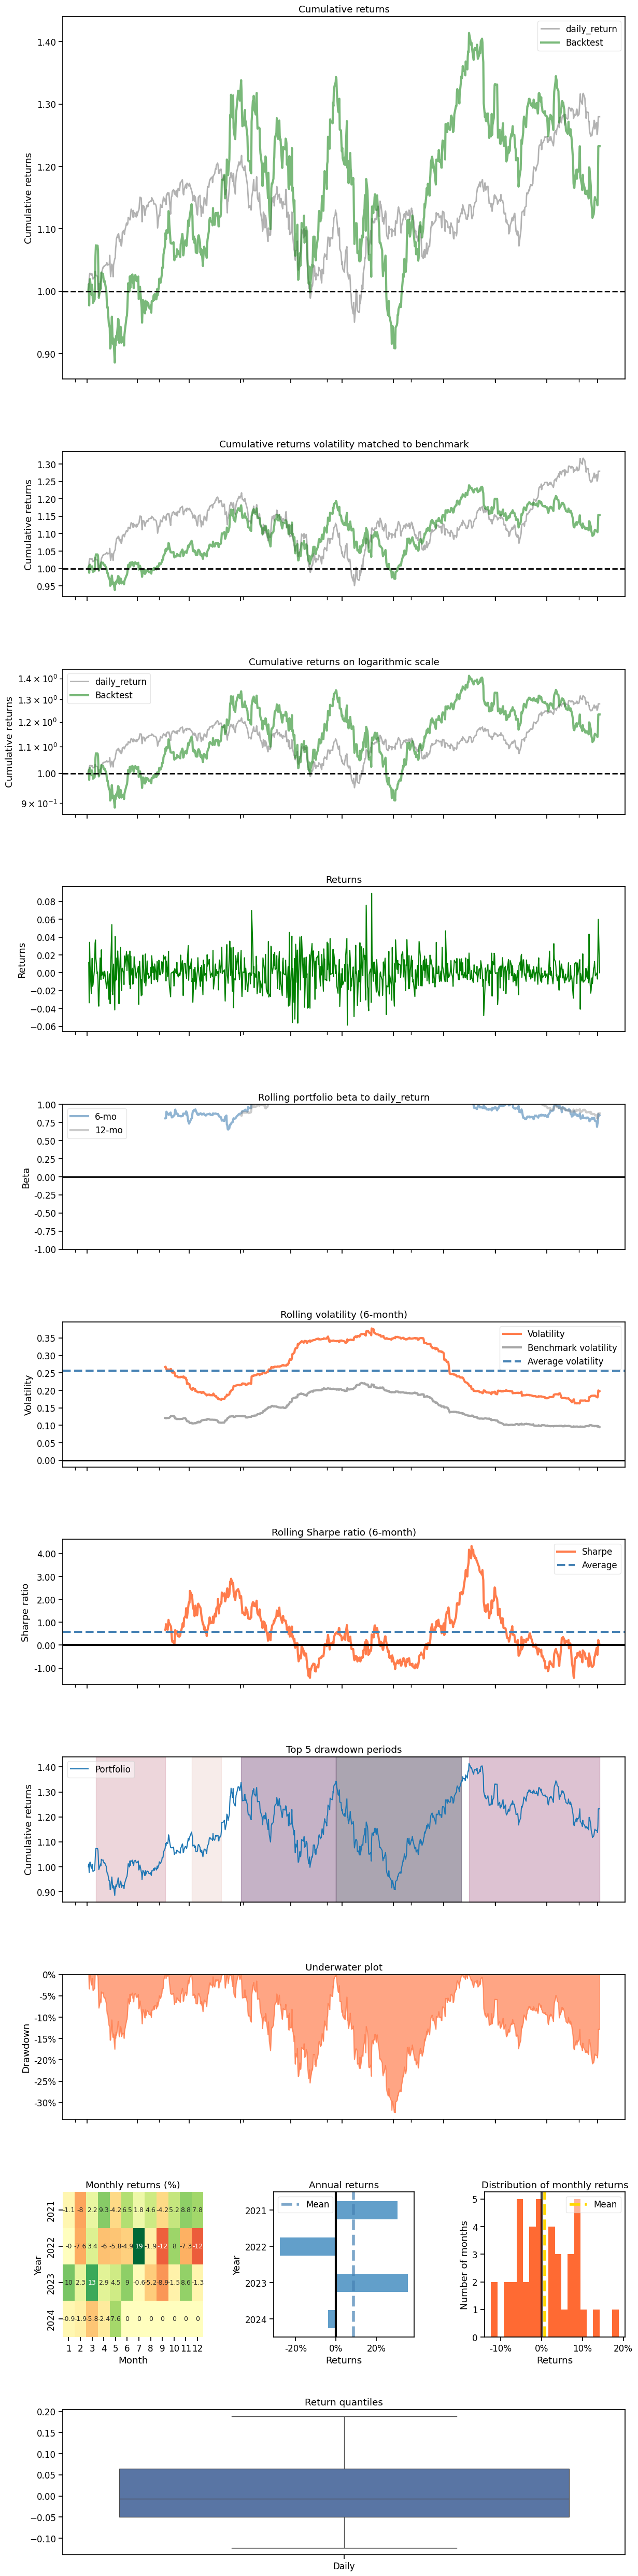

In [93]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(daily_account_value, 
            baseline_ticker = '^DJI', 
            baseline_start = TEST_START_DATE,
            baseline_end = TEST_END_DATE)

### Compare to Buy&Hold Strategy
pass in df_account_value, this information is stored in env class

<a id='6.2'></a>
## 7.2 BackTest with Buy&Hold Strategy

In [94]:
# print(DOW_30_TICKER)
# test_portfolio = DOW_30_TICKER
test_portfolio = ['AAPL']
modify_fields = ['open','high','low','close']
used_columns = ['date','close']

In [95]:
#baseline stats
print("==============Get Baseline Stats===========")
shape = daily_account_value.shape
df_hold_ = pd.DataFrame(0,index=range(shape[0]), columns=range(shape[1]))
df_hold_.columns = used_columns
df_hold_['date'] = daily_account_value.date

for stock in test_portfolio:
    df_stock_ = get_baseline(
        ticker=stock, 
        start = TEST_START_DATE,
        end = TEST_END_DATE)
    # for field in modify_fields:
    if len(df_stock_) < len(df_hold_):
        final_row = df_stock_.iloc[-1]
        new_rows = pd.DataFrame([final_row] * (len(df_hold_) - len(df_stock_)))
        df_stock_ = pd.concat([df_stock_, new_rows], ignore_index=True)
        
        for i in range(0,len(df_stock_) < len(df_hold_)):
            df_stock_.iloc[en(df_stock_)] = df_stock_.iloc[len(df_stock_-1)]
    df_stock_['close'] = df_stock_['close']/df_stock_.iloc[0]['close']/len(test_portfolio)
    df_hold_['close'] = df_hold_.close + df_stock_.close

stats = backtest_stats(df_hold_, value_col_name = 'close')

2024-05-12 22:31:05,261 peewee [DEBUG] - ('SELECT "t1"."key", "t1"."value" FROM "_kv" AS "t1" WHERE ("t1"."key" = ?) LIMIT ? OFFSET ?', ['AAPL', 1, 0])
2024-05-12 22:31:05,401 urllib3.connectionpool [DEBUG] - https://query2.finance.yahoo.com:443 "GET /v8/finance/chart/AAPL?period1=1609477200&period2=1714968000&interval=1d&includePrePost=False&events=div%2Csplits%2CcapitalGains&crumb=DVvnM.AOQYB HTTP/1.1" 200 None


==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (839, 8)
Annual return          0.116509
Cumulative returns     0.443913
Annual volatility      0.274100
Sharpe ratio           0.539295
Calmar ratio           0.376896
Stability              0.568681
Max drawdown          -0.309128
Omega ratio            1.095313
Sortino ratio          0.789072
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.971789
Daily value at risk   -0.033947
dtype: float64


The model' calculation encompass the entire timeframe, including non-working days. To address this, we need to determine the most appropriate method to fill up the weekend plots, for example backfilling.

In [96]:
df_hold = pd.DataFrame()
df_hold['date'] = daily_account_value['date']
df_hold['hold'] = df_hold_['close'] / df_hold_['close'][0] * env_kwargs["initial_amount"]
# print("df_hold: ", df_hold)
# df_dji.to_csv("df_dji.csv")
df_hold = df_hold.set_index(df_hold.columns[0])
print("df_hold: ", df_hold)
# df_hold.to_csv("df_dji+.csv")

# df_account_value.to_csv('df_account_value.csv')

df_hold:                      hold
date                    
2021-01-04  1.000000e+06
2021-01-05  1.012363e+06
2021-01-06  9.782858e+05
2021-01-07  1.011668e+06
2021-01-08  1.020400e+06
...                  ...
2024-04-30  1.341159e+06
2024-05-01  1.333049e+06
2024-05-02  1.362418e+06
2024-05-03  1.443913e+06
2024-05-06  1.443913e+06

[840 rows x 1 columns]


==============Compare to Buy&Hold===========
result:                     stock          hold
date                                  
2021-01-04  1.000000e+06  1.000000e+06
2021-01-05  1.011364e+06  1.012363e+06
2021-01-06  9.772857e+05  9.782858e+05
2021-01-07  1.010668e+06  1.011668e+06
2021-01-08  1.019400e+06  1.020400e+06
...                  ...           ...
2024-04-29  1.145744e+06  1.366119e+06
2024-04-30  1.145744e+06  1.341159e+06
2024-05-01  1.137670e+06  1.333049e+06
2024-05-02  1.162761e+06  1.362418e+06
2024-05-03  1.232386e+06  1.443913e+06

[839 rows x 2 columns]


<Figure size 1500x500 with 0 Axes>

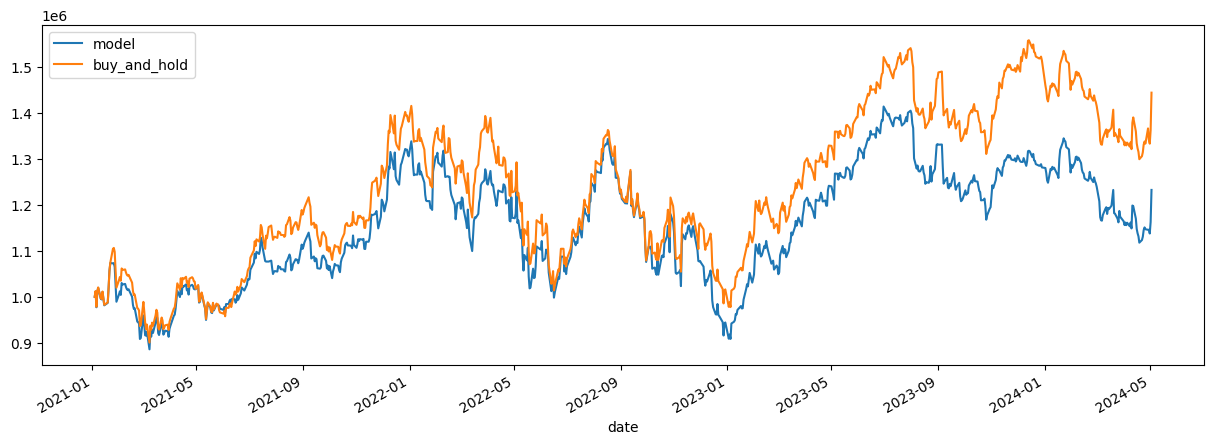

In [97]:
print("==============Compare to Buy&Hold===========")
df_result = pd.DataFrame({'date': df_account_value_ppo['date'], 'stock': df_account_value_ppo['account_value']})
df_result = df_result.set_index('date')

result = pd.DataFrame()
result = pd.merge(df_result, df_hold, left_index=True, right_index=True)
print("result: ", result)
# result.to_csv("result.csv")
result.columns = ['model', 'buy_and_hold']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

<a id='7'></a>
# 8. Save and load model #

<a id='7.1'></a>
## 8.1 Save model

### 8.1.1 Save trained model

In [81]:
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/Binhlai_Testing


In [82]:
model_name = "./"+TRAINED_MODEL_DIR+"/main_dow30_oneTic_filter_3hiden_ppo11_23m_steps"
model_name

'./trained_models/main_dow30_oneTic_filter_3hiden_ppo11_23m_steps'

In [83]:
trained_ppo.save(model_name)

### 8.1.2 Save model as ONNX file

In [74]:
import torch as th
import torch.onnx
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import DDPG
from stable_baselines3.common.policies import BasePolicy
from typing import Tuple

In [72]:
class OnnxableSB3Policy(th.nn.Module):
    def __init__(self, policy: BasePolicy):
        super().__init__()
        self.policy = policy

    def forward(self, observation: th.Tensor) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        # NOTE: Preprocessing is included, but postprocessing
        # (clipping/inscaling actions) is not,
        # If needed, you also need to transpose the images so that they are channel first
        # use deterministic=False if you want to export the stochastic policy
        # policy() returns `actions, values, log_prob` for PPO
        return self.policy(observation, deterministic=True)

In [76]:
onnx_policy = OnnxableSB3Policy(trained_ppo.policy)
observation_size = trained_ppo.observation_space.shape
dummy_input = th.randn(1, *observation_size)

# th.onnx.export(
#     onnx_policy,
#     dummy_input,
#     "main_dow30_randomTic_discrete_shortSell_256neu_ppo_4m_steps.onnx",
#     opset_version=17,
#     input_names=["input"],
# )

In [77]:
onnx_policy

OnnxableSB3Policy(
  (policy): ActorCriticPolicy(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (pi_features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (vf_features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (mlp_extractor): MlpExtractor(
      (policy_net): Sequential(
        (0): Linear(in_features=19, out_features=256, bias=True)
        (1): Tanh()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): Tanh()
      )
      (value_net): Sequential(
        (0): Linear(in_features=19, out_features=256, bias=True)
        (1): Tanh()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): Tanh()
      )
    )
    (action_net): Linear(in_features=256, out_features=3, bias=True)
    (value_net): Linear(in_features=256, out_features=1, bias=True)
  )
)

<a id='7.2'></a>
## 8.2 Load model

<a id='7.2.1'></a>
### 8.2.1 Load trained model

In [74]:
from stable_baselines3 import PPO
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/Binhlai_Testing


In [75]:
model_name = "./"+TRAINED_MODEL_DIR+"/main_dow30_oneTic_filter_3hiden_ppo11_23m_steps"
model_name

'./trained_models/main_dow30_oneTic_filter_3hiden_ppo11_23m_steps'

In [76]:
trained_model = PPO.load(model_name)

Continous training based on the previous model at [**Part5. Train DRL Agents**](#5)

In [59]:
# #Establish the training environment using StockTradingEnv() class
# agent = DRLAgent(env = env_train)
# trained_model.env = env_train

In [64]:
# trained_ppo = agent.train_model(model=trained_model, 
#                              tb_log_name='ppo',
#                              total_timesteps=total_training_step)

#### Test loaded model

In [ ]:
test_env = StockTradingEnv(df = trade_data, **env_kwargs)

In [ ]:
test_step = 1000
test_result = []
test_env.reset()
for i in range(0,test_step):
    observation = [test_env.state]
    observation = np.array(observation).astype(np.float32)
    actions, values, log_prob = ort_sess.run(None, {"input": observation})
    result = test_env.step(actions)
    test_result.append(result[1])
    if result[2] == True:
        break

### 8.2.2 Load ONNX model

In [ ]:
import onnx
import onnxruntime as ort
import numpy as np

In [ ]:
onnx_path = "all_in_one_ppo.onnx"
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

# # Check that the predictions are the same
# with th.no_grad():
#     print(model.policy(th.as_tensor(observation), deterministic=True))

In [ ]:
observation = np.zeros((1, state_space)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
actions, values, log_prob = ort_sess.run(None, {"input": observation})
print(actions, values, log_prob)